In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

In [2]:
old_bonds = pd.read_csv('../api/.cache2/bonds.csv')
old_etfs = pd.read_csv('../api/.cache2/etfs.csv')
old_shares = pd.read_csv('../api/.cache2/shares.csv')

new_bonds = pd.read_csv('../api/.cache/bonds.csv')
new_etfs = pd.read_csv('../api/.cache/etfs.csv')
new_shares = pd.read_csv('../api/.cache/shares.csv')

In [3]:
old_bonds.columns

Index(['figi', 'ticker', 'class_code', 'isin', 'currency', 'name', 'exchange',
       'coupon_quantity_per_year', 'maturity_date', 'nominal',
       'initial_nominal', 'placement_price', 'aci_value', 'country_of_risk',
       'country_of_risk_name', 'sector', 'issue_kind', 'issue_size',
       'issue_size_plan', 'liquidity_flag', 'risk_level',
       'min_price_increment', 'lot', 'price', 'rub_price', 'company_rating',
       'mean_return', 'stability', 'inverse_drawdown', 'sharpe_ratio',
       'sortino_ratio', 'trend_slope', 'price_rating', 'ratings',
       'candle_price'],
      dtype='object')

In [4]:
valid_columns = list(set(old_bonds.columns) & set(old_etfs.columns) & set(old_shares.columns))

In [5]:
old_bonds = old_bonds[valid_columns]
old_etfs = old_etfs[valid_columns]
old_shares = old_shares[valid_columns]

In [6]:
old_bonds = old_bonds.dropna()
old_etfs = old_etfs.dropna()
old_shares = old_shares.dropna()

In [7]:
useless_columns = [
    "ticker", "rub_price", "name", "company_rating", "isin", "price_rating", "ratings", "price", "country_of_risk_name"
]

old_bonds = old_bonds.drop(useless_columns, axis=1)
old_etfs = old_etfs.drop(useless_columns, axis=1)
old_shares = old_shares.drop(useless_columns, axis=1)

In [8]:
list(old_bonds.columns) == list(old_etfs.columns) == list(old_shares.columns)

True

In [9]:
train = pd.concat([old_bonds, old_etfs, old_shares])

In [10]:
exchange_encoder = LabelEncoder()
class_code_encoder = LabelEncoder()
currency_encoder = LabelEncoder()
sector_encoder = LabelEncoder()
country_of_risk_encoder = LabelEncoder()

In [11]:
"industrials" in sector_encoder.classes_

AttributeError: 'LabelEncoder' object has no attribute 'classes_'

In [12]:
train.exchange = exchange_encoder.fit_transform(train.exchange)
train.currency = currency_encoder.fit_transform(train.currency)
train.class_code = class_code_encoder.fit_transform(train.class_code)
train.country_of_risk = country_of_risk_encoder.fit_transform(train.country_of_risk)
train.sector = sector_encoder.fit_transform(train.sector)

In [13]:
new_bonds = new_bonds[valid_columns].drop(useless_columns, axis=1)
new_etfs = new_etfs[valid_columns].drop(useless_columns, axis=1)
new_shares = new_shares[valid_columns].drop(useless_columns, axis=1)

val = pd.concat([new_bonds, new_etfs, new_shares])

In [14]:
val[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1)

,price,figi
0,96.050000,TCS00A107D74
1,59.560000,BBG00XH4W3N3
2,77.830000,BBG00Z8KGGC3
3,68.050000,TCS00A102D46
4,95.100000,ISSUANCEPRLS
...,...,...
168,8.495000,BBG004S68BR5
169,0.007204,BBG000QFH687
170,8.400000,BBG0027F0Y27
171,111.450000,BBG004S68FR6


In [15]:
import numpy as np

train.loc[np.isin(train.figi, val.figi)].shape == train.shape

False

In [16]:
train = train.loc[np.isin(train.figi, val.figi)]

In [17]:
prices = pd.merge(
    val[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1), train[["candle_price",
                                                                                    "figi"]],
    on="figi",
    how="left"
)

In [18]:
na_figis = prices[prices.isna()].figi

In [19]:
prices = prices.dropna()

In [20]:
prices["target"] = prices.price > prices.candle_price

In [21]:
prices.dtypes

price           float64
figi             object
candle_price    float64
target             bool
dtype: object

In [22]:
train["target"] = train.figi.apply(lambda x: prices.loc[prices.figi == x].iloc[0].target)

In [23]:
train = train.drop(["figi", "candle_price"], axis=1)

In [24]:
train.columns

Index(['inverse_drawdown', 'mean_return', 'country_of_risk', 'class_code',
       'currency', 'sharpe_ratio', 'trend_slope', 'sortino_ratio', 'exchange',
       'lot', 'sector', 'stability', 'target'],
      dtype='object')

In [25]:
train.dtypes

inverse_drawdown    float64
mean_return         float64
country_of_risk       int64
class_code            int64
currency              int64
sharpe_ratio        float64
trend_slope         float64
sortino_ratio       float64
exchange              int64
lot                   int64
sector                int64
stability           float64
target                 bool
dtype: object

In [26]:
real_bonds = pd.read_csv('../api/.actual_cache/bonds.csv')
real_etfs = pd.read_csv('../api/.actual_cache/etfs.csv')
real_shares = pd.read_csv('../api/.actual_cache/shares.csv')

In [27]:
real_bonds = real_bonds[valid_columns].drop(useless_columns, axis=1)
real_etfs = real_etfs[valid_columns].drop(useless_columns, axis=1)
real_shares = real_shares[valid_columns].drop(useless_columns, axis=1)

In [28]:
test = pd.concat([real_bonds, real_etfs, real_shares])

In [29]:
test = test.dropna()

In [30]:
val.figi.nunique(), test.figi.nunique()

(1342, 3177)

In [31]:
test_prices = pd.merge(
    test[["candle_price", "figi"]].rename({"candle_price": "price"}, axis=1), val[["candle_price", "figi"]],
    on="figi",
    how="left"
)

In [32]:
test_prices = test_prices.dropna()
test_prices["target"] = test_prices.price > test_prices.candle_price
X_test = val.loc[np.isin(val.figi, test.figi)]
Y_test = X_test.figi.apply(lambda x: test_prices.loc[test_prices.figi == x].iloc[0].target)

In [33]:
X_test = X_test.drop(["figi", "candle_price"], axis=1)

In [34]:
model = CatBoostClassifier(iterations=10001, depth=5)

In [35]:
model.fit(
    train.drop("target", axis=1),
    train.target,
    verbose=1000
)

Learning rate set to 0.001393
0:	learn: 0.6927915	total: 57.8ms	remaining: 9m 38s
1000:	learn: 0.5613505	total: 990ms	remaining: 8.9s
2000:	learn: 0.5280424	total: 2.05s	remaining: 8.21s
3000:	learn: 0.5080508	total: 3.2s	remaining: 7.47s
4000:	learn: 0.4916144	total: 4.35s	remaining: 6.52s
5000:	learn: 0.4753030	total: 5.49s	remaining: 5.49s
6000:	learn: 0.4557527	total: 6.49s	remaining: 4.32s
7000:	learn: 0.4335507	total: 7.18s	remaining: 3.08s
8000:	learn: 0.4125016	total: 7.85s	remaining: 1.96s
9000:	learn: 0.3934285	total: 8.53s	remaining: 948ms
10000:	learn: 0.3763634	total: 9.21s	remaining: 0us


In [36]:
from sklearn.metrics import classification_report

In [37]:
country_of_risk_encoder.classes_

array(['AR', 'BE', 'BR', 'CH', 'CN', 'DE', 'ES', 'FI', 'FR', 'GB', 'HK',
       'IL', 'IN', 'IT', 'KR', 'KZ', 'NL', 'PE', 'RU', 'SE', 'SG', 'US',
       'UY'], dtype=object)

In [39]:
X_test.loc[~np.isin(X_test.country_of_risk, country_of_risk_encoder.classes_), "country_of_risk"] = "RU"

In [40]:
X_test.exchange = exchange_encoder.transform(X_test.exchange)
X_test.currency = currency_encoder.transform(X_test.currency)
X_test.class_code = class_code_encoder.transform(X_test.class_code)
X_test.sector = sector_encoder.transform(X_test.sector)
X_test.country_of_risk = country_of_risk_encoder.transform(X_test.country_of_risk)

In [41]:
print(classification_report(Y_test.astype(str), model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.82      0.77      0.79      1004
        True       0.38      0.46      0.41       313

    accuracy                           0.69      1317
   macro avg       0.60      0.61      0.60      1317
weighted avg       0.71      0.69      0.70      1317



In [42]:
bonds = pd.read_csv('../api/.cache/bonds.csv')
etfs = pd.read_csv('../api/.cache/etfs.csv')
shares = pd.read_csv('../api/.cache/shares.csv')

In [63]:
bonds_nans = bonds[X_test.columns].isna().any(axis=1)

In [65]:
bonds_nans

0       False
1       False
2       False
3       False
4       False
        ...  
1092    False
1093    False
1094    False
1095    False
1096    False
Length: 1097, dtype: bool

In [64]:
score = model.predict_proba(bonds[X_test.columns][~bonds_nans])

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="RU": Cannot convert 'b'RU'' to float

In [45]:
bonds.loc[~bonds_nans, "ratings"] = score[:, 1]
bonds.loc[bonds_nans, "ratings"] = 0

NameError: name 'score' is not defined

In [46]:
bonds

,figi,ticker,class_code,isin,currency,name,exchange,coupon_quantity_per_year,maturity_date,nominal,...,company_rating,mean_return,stability,inverse_drawdown,sharpe_ratio,sortino_ratio,trend_slope,price_rating,ratings,candle_price
0,TCS00A107D74,RU000A107D74,TQCB,RU000A107D74,rub,ЭнергоТехСервис 001P-05,MOEX,12,02/12/2025,1000.00,...,6.293961,5.478607,7.072402,2.321849,5.604616,5.315462,4.959775,5.125452,373.745370,96.05
1,BBG00XH4W3N3,RU000A101RZ3,TQCB,RU000A101RZ3,rub,Казахстан выпуск 11,MOEX,2,11/09/2030,1000.00,...,3.675523,2.037783,6.312588,6.928665,2.235709,2.225757,2.040463,3.630161,287.397906,59.56
2,BBG00Z8KGGC3,RU000A102R73,TQCB,RU000A102R73,rub,Банк Открытие БО-П выпуск 7,MOEX,2,06/02/2026,1000.00,...,5.425456,2.576455,0.000000,9.113294,6.559297,6.287767,0.008493,4.090884,282.098997,77.83
3,TCS00A102D46,RU000A102D46,TQCB,RU000A102D46,rub,ДОМ.РФ ИА 018P,MOEX,4,28/02/2051,380.15,...,5.401428,2.167806,4.603457,7.343594,3.974293,4.113328,1.809578,4.002009,295.531888,68.05
4,ISSUANCEPRLS,RU000A1022E6,TQCB,RU000A1022E6,rub,ПР-Лизинг 002P-01,MOEX,12,10/08/2029,1000.00,...,6.306879,6.437097,7.994501,1.562965,6.717169,6.388216,6.236490,5.889406,387.773694,95.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,TCS00A105Q63,RU000A105Q63,TQCB,RU000A105Q63,rub,Уральская Сталь выпуск 1,MOEX,2,25/12/2025,1000.00,...,4.992343,5.023308,5.829206,2.719374,5.775431,5.498220,5.150632,4.999362,390.514905,88.60
1093,BBG012YS2TP2,RU000A103VD8,TQCB,RU000A103VD8,rub,МСБ-Лизинг 002P выпуск 5,MOEX,12,18/09/2026,638.86,...,6.204105,5.257028,5.383971,2.627258,6.155981,5.912684,5.499200,5.139354,401.488893,91.28
1094,TCS00A105HJ9,RU000A105HJ9,TQCB,RU000A105HJ9,rub,Альфа-Банк 002Р-18,MOEX,2,29/11/2024,1000.00,...,5.442307,6.950916,8.011526,0.537598,7.731825,7.442248,7.035189,6.284884,417.450488,99.09
1095,TCS00A104735,RU000A104735,TQCB,RU000A104735,rub,ГК Пионер-001P выпуск 6,MOEX,4,04/12/2025,1000.00,...,4.801130,5.907525,7.932433,1.360698,5.726598,5.075679,5.807311,5.301707,390.098865,92.30


In [47]:
shares_nans = shares[X_test.columns].isna().any(axis=1)
score = model.predict_proba(shares[X_test.columns][~shares_nans])
shares.loc[~shares_nans, "ratings"] = score[:, 1]
shares.loc[shares_nans, "ratings"] = 0

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="RU": Cannot convert 'b'RU'' to float

In [48]:
shares

,figi,ticker,class_code,isin,currency,name,exchange,ipo_date,nominal,issue_size,...,company_rating,mean_return,stability,inverse_drawdown,sharpe_ratio,sortino_ratio,trend_slope,price_rating,ratings,candle_price
0,TCS007940839,KZIZP,MTQR,RU0007940839,rub,Красногорский завод им. С.А. Зверева - привиле...,otc_ncc,12/10/2007,0.10,1343020,...,3.708377,0.000000,2.288596,10.000000,1.225197,1.263783,0.111665,2.481540,270.108247,302.990000
1,TCS00A108ZR8,DATA,TQBR,RU000A108ZR8,rub,Группа Аренадата,moex_extended,15/04/2024,0.05,200000000,...,7.724214,10.000000,8.014655,0.000000,8.890543,9.193300,10.000000,7.683083,443.442764,111.380000
2,BBG000FWGSZ5,IRKT,TQBR,RU0006752979,rub,Яковлев,MOEX_DEALER_WEEKEND,15/08/2002,3.00,12051279624,...,9.611296,3.251468,2.911034,8.364985,3.593304,3.334751,2.541478,3.999504,291.436182,43.550000
3,BBG004S68CV8,VSMO,TQBR,RU0009100291,rub,ВСМПО-АВИСМА,MOEX_DEALER_WEEKEND,11/11/2004,1.00,11529538,...,6.693208,2.328148,5.884966,5.291744,2.560762,2.241224,2.903713,3.535093,331.973074,26580.000000
4,BBG000Q7ZZY2,UNAC,TQBR,RU000A0JPLZ7,rub,Объединенная авиастроительная корпорация,MOEX_DEALER_WEEKEND,26/04/2013,0.27,994436434417,...,9.802516,2.025850,3.348198,10.000000,2.850808,2.415672,0.000000,3.440088,235.092484,0.771000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,BBG004S68BR5,NMTP,TQBR,RU0009084446,rub,НМТП,MOEX_DEALER_WEEKEND,04/06/2003,0.01,19259815400,...,9.625636,2.253016,5.589684,4.732105,2.574496,2.618918,2.607009,3.395871,344.543444,8.495000
169,BBG000QFH687,TGKA,TQBR,RU000A0JNUD0,rub,ТГК-1,MOEX_DEALER_WEEKEND,17/05/2005,0.01,3854341416571,...,9.660532,2.164127,7.057391,3.701367,1.966651,1.731214,2.925508,3.257710,300.433764,0.007204
170,BBG0027F0Y27,CNTLP,TQBR,RU0007665139,rub,Центральный Телеграф - акции привилегированные,moex_extended,20/12/2002,1.00,55389000,...,3.818459,2.471787,6.063629,4.820033,2.640975,2.469703,2.557676,3.503967,332.585289,8.400000
171,BBG004S68FR6,MTLRP,TQBR,RU000A0JPV70,rub,Мечел - Привилегированные акции,MOEX_DEALER_WEEKEND,05/06/2008,10.00,138756915,...,7.218503,0.000000,5.298516,10.000000,0.000000,0.000000,0.000000,2.549753,237.324387,111.450000


In [49]:
etfs_nans = etfs[X_test.columns].isna().any(axis=1)
score = model.predict_proba(etfs[X_test.columns][~etfs_nans])
etfs.loc[~etfs_nans, "ratings"] = score[:, 1]
etfs.loc[etfs_nans, "ratings"] = 0

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="DE": Cannot convert 'b'DE'' to float

In [50]:
bonds["ratings"] = bonds["ratings"] * 1000
shares["ratings"] = shares["ratings"] * 1000
etfs["ratings"] = etfs["ratings"] * 1000

In [51]:
bonds.to_csv('../api/.cache/bonds.csv', index=False)
shares.to_csv('../api/.cache/shares.csv', index=False)
etfs.to_csv('../api/.cache/etfs.csv', index=False)

In [52]:
model.get_feature_importance()

array([14.36306357,  9.61895767,  0.68099238, 10.17674443,  0.72714222,
        8.53988313, 15.4736288 ,  9.62917164,  8.82310319,  4.28443962,
        6.91445172, 10.76842163])

In [53]:
pd.DataFrame({"column": X_test.columns, "importance": model.get_feature_importance()})

,column,importance
0,inverse_drawdown,14.363064
1,mean_return,9.618958
2,country_of_risk,0.680992
3,class_code,10.176744
4,currency,0.727142
5,sharpe_ratio,8.539883
6,trend_slope,15.473629
7,sortino_ratio,9.629172
8,exchange,8.823103
9,lot,4.284440


In [54]:
num_columns = train

In [55]:
indexes = (train.drop("target", axis=1).dtypes != "object")

In [56]:
num_columns = indexes[indexes.values].index.values

In [57]:
from sklearn.linear_model import LogisticRegressionCV

In [58]:
model2 = LogisticRegressionCV()

In [59]:
model2.fit(train[num_columns], train["target"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

LogisticRegressionCV()

In [60]:
bonds_nans = bonds[X_test.columns].isna().any(axis=1)
pred = bonds[list(set(X_test.columns) & set(num_columns))][~bonds_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
bonds.loc[~bonds_nans, "ratings"] = score[:, 1] * 1000
bonds.loc[bonds_nans, "ratings"] = 0

ValueError: could not convert string to float: 'RU'

In [269]:
shares_nans = shares[X_test.columns].isna().any(axis=1)
pred = shares[list(set(X_test.columns) & set(num_columns))][~shares_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
shares.loc[~shares_nans, "ratings"] = score[:, 1] * 1000
shares.loc[shares_nans, "ratings"] = 0

In [270]:
etfs_nans = etfs[X_test.columns].isna().any(axis=1)
pred = etfs[list(set(X_test.columns) & set(num_columns))][~etfs_nans]
pred = pred.reindex(columns=num_columns)
score = model2.predict_proba(pred)
etfs.loc[~etfs_nans, "ratings"] = score[:, 1] * 1000
etfs.loc[etfs_nans, "ratings"] = 0

In [271]:
bonds.to_csv('../api/.cache/bonds.csv', index=False)
shares.to_csv('../api/.cache/shares.csv', index=False)
etfs.to_csv('../api/.cache/etfs.csv', index=False)

In [272]:
print(model2.get_params())

{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [158]:
X_test.class_code = class_code_encoder.transform(X_test.class_code)
X_test.currency = currency_encoder.transform(X_test.currency)

In [161]:
X_test.exchange = exchange_encoder.transform(X_test.exchange)

In [162]:
X_test

,country_of_risk,stability,exchange,class_code,currency,mean_return,sortino_ratio,lot,trend_slope,sharpe_ratio,inverse_drawdown,sector
0,18,7.072402,0,7,2,5.478607,5.315462,1,4.959775,5.604616,2.321849,9
1,15,6.312588,0,7,2,2.037783,2.225757,1,2.040463,2.235709,6.928665,5
2,18,0.000000,0,7,2,2.576455,6.287767,1,0.008493,6.559297,9.113294,4
3,18,4.603457,0,7,2,2.167806,4.113328,1,1.809578,3.974293,7.343594,4
4,18,7.994501,0,7,2,6.437097,6.388216,1,6.236490,6.717169,1.562965,13
...,...,...,...,...,...,...,...,...,...,...,...,...
168,18,5.589684,1,6,2,2.253016,2.618918,100,2.607009,2.574496,4.732105,9
169,18,7.057391,1,6,2,2.164127,1.731214,100000,2.925508,1.966651,3.701367,16
170,18,6.063629,7,6,2,2.471787,2.469703,100,2.557676,2.640975,4.820033,15
171,18,5.298516,1,6,2,0.000000,0.000000,10,0.000000,0.000000,10.000000,11


In [163]:
preds = X_test[list(set(X_test.columns) & set(num_columns))]
preds = preds.reindex(columns=num_columns)
preds = model2.predict(preds)

In [164]:
Y_test.shape, preds.shape

((1317,), (1317,))

In [165]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

       False       0.77      0.91      0.83      1004
        True       0.31      0.13      0.18       313

    accuracy                           0.72      1317
   macro avg       0.54      0.52      0.51      1317
weighted avg       0.66      0.72      0.68      1317



([<matplotlib.patches.Wedge at 0x1627cff10>,
 [Text(-0.8073761396725034, 0.7470902014399107, 'False'),
  Text(0.8073761046986861, -0.7470902392359148, 'True')])

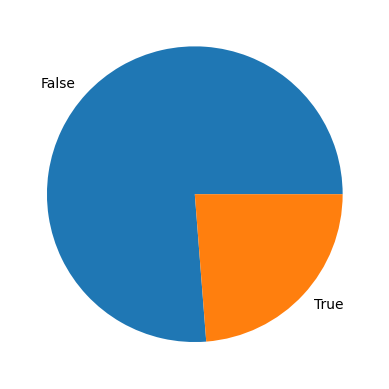

In [166]:
import matplotlib.pyplot as plt

plt.pie(Y_test.value_counts(), labels=Y_test.value_counts().index)

In [167]:
print(classification_report(Y_test, model2.predict(X_test[num_columns])))

              precision    recall  f1-score   support

       False       0.77      0.91      0.83      1004
        True       0.31      0.13      0.18       313

    accuracy                           0.72      1317
   macro avg       0.54      0.52      0.51      1317
weighted avg       0.66      0.72      0.68      1317



In [254]:
print(classification_report(train.target.astype(str), model.predict(train.drop("target", axis=1))))

              precision    recall  f1-score   support

       False       0.80      0.90      0.85       803
        True       0.80      0.63      0.70       492

    accuracy                           0.80      1295
   macro avg       0.80      0.76      0.77      1295
weighted avg       0.80      0.80      0.79      1295

